In [1]:
import warnings
warnings.filterwarnings("ignore")

Установим необходимые библиотеки:

In [3]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 8.2 MB 14.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=74421dd2c6d2eba6780f8bd0b5805f7011afeec411796eebd5b284ca7a6a62aa
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [4]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=bea789840547ed303350454319ffc3d32558b331f2eafb1326dcbb8f3613a8be
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stop_words
import string
import re
import pymorphy2

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool

In [7]:
import time

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
device

device(type='cuda')

###### **Подготовка данных**

- подгрузим данные
- выберем классы, содержащие больше 500 примеров
- посмотрим на распределение данных

In [11]:
# data_path = "./DATA/meatinfo.csv"
data_path = "./meatinfo.csv"

df = pd.read_csv(data_path, sep=";")

df

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17888,"Ягнятина, шея, бк",Ягнятина
17889,Язык ягненка (н.зеландия) Отварные языки ягнят...,Ягнятина
17890,"Ягнятина, язык, зачищ. цена 100 руб.",Ягнятина
17891,"Як, задние части, 1 категория цена 550 руб.",Як


In [12]:
df.mtype.value_counts()

Говядина                                                                                   8422
Свинина                                                                                    3050
Кура                                                                                       1571
Индейка                                                                                    1337
Баранина                                                                                   1116
Цыпленок                                                                                    942
Кролик                                                                                      334
Утка                                                                                        195
Оленина                                                                                     193
Конина                                                                                      176
Гусь                                    

In [13]:
def get_reduced_df(df, threshold=500):
    
    cnt_df = df.mtype.value_counts()
    names = cnt_df[cnt_df >= threshold].index.tolist()
    
    new_df = df[df.mtype.isin(names)]
    
    new_df.mtype.value_counts().plot(kind="bar")
    plt.show()
    
    return new_df


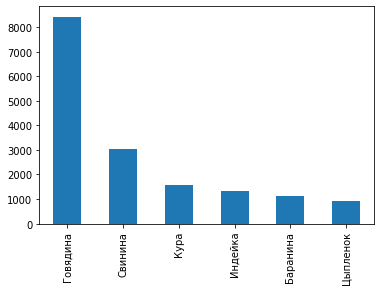

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок
17819,"Цыпленок, шея, без кожи",Цыпленок


In [14]:
reduced_df = get_reduced_df(df)

reduced_df

У нас осталось только 6 классов. Заметим, что в датасете присутствует дисбаланс классов. Будем иметь это ввиду при обучении моделей.

######**Очистка данных**

Подготовим данные для обучения:
    
- выбросим знаки пунктуации
- выбросим сдвоенные пробелы
- сведем весь текст к нижнему регистру
- лемматизируем каждое слово в тексте
- выбросим стоп-слова

In [15]:
russian_stopwords = stop_words.get_stop_words('ru')
russian_stopwords.extend(['...', '«', '»', 
                          'здравствуйте', 'здравствуй',
                          'до свидания', 'добрый день', 
                          'добрый вечер', 'доброе утро'])


# def _remove_numbers(text):
#     return ''.join([i if not i.isdigit() else ' ' for i in text])


def _remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in russian_stopwords])


def _remove_punctuation(text):
    return ''.join([ch if ch not in string.punctuation else ' ' for ch in text])


def _remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)


def clean_text(df):
    df["clean_text"] = df.text.apply(lambda x: x.lower())
    df["clean_text"] = df["clean_text"].apply(lambda x: _remove_punctuation(x))
    df["clean_text"] = df["clean_text"].apply(lambda x: _remove_multiple_spaces(x))
    df["clean_text"] = df["clean_text"].apply(lambda x: _remove_stop_words(x))
    df["clean_text"] = df["clean_text"].apply(lambda x: x.strip())
    return df


def lemmatization(df, text_len_threshold=None):
    
    morph = pymorphy2.MorphAnalyzer()
    tqdm.pandas()
    
    df["text_lemm"] = \
    df.clean_text.progress_apply(lambda x: [morph.parse(word)[0].normal_form for word in x.split(' ')])

    if text_len_threshold is not None:
        df["text_lemm"].apply(lambda x: x if len(x) > text_len_threshold else '')

    df["text_lemm"] = df["text_lemm"].apply(lambda x: ' '.join(x))
    
    return df


def process_text(df):
    df = df.copy()
    df = clean_text(df)
    df = lemmatization(df)
    return df


In [16]:
processed_df = process_text(reduced_df)

processed_df

100%|██████████| 16438/16438 [00:45<00:00, 360.83it/s]


,text,mtype,clean_text,text_lemm
0,12 частей баранина 12 частей баранина,Баранина,12 частей баранина 12 частей баранина,12 часть баранина 12 часть баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина,баранина 12 частей зам цена 260 руб,баранина 12 часть зам цена 260 руб
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина,баранина 12 частей зам цена 315 руб,баранина 12 часть зам цена 315 руб
3,"Баранина, 12 частей, охл.",Баранина,баранина 12 частей охл,баранина 12 часть охл
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина,баранина 12 частей охл цена 220 руб,баранина 12 часть охл цена 220 руб
...,...,...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок,цыпленок четвертина задняя,цыплёнок четвертина задний
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок,цыпленок четвертина задняя цена 100 руб,цыплёнок четвертина задний цена 100 руб
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок,цб шеи п ф свеженка гост зам пак шеи куриные п...,цб шея п ф свежёнка гост зам пак шея куриный п...
17819,"Цыпленок, шея, без кожи",Цыпленок,цыпленок шея кожи,цыплёнок шея кожа


###### **Train_test_split**

Разобьем данные на тренировочную и тестовую выборки (80% / 20%). Проконтролируем, что соотношение классов в обеих выборках одинаково.

In [17]:
def get_train_test_split(df, test_size=0.2, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(df.text_lemm, 
                                                        df.mtype, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    fig, (ax0, ax1) = plt.subplots(1, 2)

    ax0.bar(y_train.value_counts().index, y_train.value_counts().values)
    ax1.bar(y_test.value_counts().index, y_test.value_counts().values)
    
    ax0.set_xticklabels(y_train.value_counts().index, rotation = 90)
    ax1.set_xticklabels(y_test.value_counts().index, rotation = 90)
    
    ax0.set_title("Train")
    ax1.set_title("Test")
    
    plt.show()
    
    return pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test)

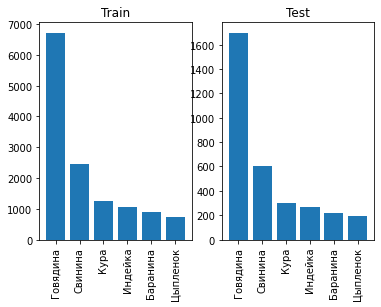

In [18]:
X_train, X_test, y_train, y_test = get_train_test_split(processed_df)

###### **Class weights**

Попробуем решить проблему дисбаланса классов с помощью присвоения весов каждому классу: чем реже встречается класс в датасете, тем выше его вес.

In [20]:
def get_class_weights(y_train):

    classes = y_train.mtype.unique().tolist()
    y = y_train.mtype.tolist()
    
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))
    
    return class_weights

In [21]:
class_weights = get_class_weights(y_train)

class_weights

{'Говядина': 0.3259468570295459,
 'Свинина': 0.8974883974883975,
 'Цыпленок': 2.9378909740840036,
 'Кура': 1.7284437434279705,
 'Баранина': 2.443329617242661,
 'Индейка': 2.0425598011804906}

###### **Test example**

добавим 3 указанных в задании примера

In [22]:
# test_example_path = "./DATA/test_example.csv"
test_example_path = "./test_example.csv"
test_df = pd.read_csv(test_example_path, sep=";")
test_df

,text,mtype
0,"1. Говядина блочная 2 сорт в наличии ООО ""Агро...",Говядина
1,2. Куриная разделка Продам кур и куриную разде...,Кура
2,3. Говяжью мукозу Продам говяжью мукозу в охл ...,Говядина


In [23]:
processed_test_df = process_text(test_df)

processed_test_df

100%|██████████| 3/3 [00:00<00:00, 251.96it/s]


,text,mtype,clean_text,text_lemm
0,"1. Говядина блочная 2 сорт в наличии ООО ""Агро...",Говядина,1 говядина блочная 2 сорт наличии ооо агросоюз...,1 говядина блочный 2 сорт наличие ооо агросоюз...
1,2. Куриная разделка Продам кур и куриную разде...,Кура,2 куриная разделка продам кур куриную разделку...,2 куриный разделка продать кура куриный раздел...
2,3. Говяжью мукозу Продам говяжью мукозу в охл ...,Говядина,3 говяжью мукозу продам говяжью мукозу охл зам...,3 говяжий мукоза продать говяжий мукоза охл за...


In [76]:
processed_test_df.mtype = processed_test_df.mtype.apply(lambda x: x.strip())

In [77]:
X_test_example = processed_test_df[["text_lemm"]]
y_test_example = processed_test_df[["mtype"]]

###### **Metrics**

Подготовим функции для вывода расширенных метрик классификации и матрицы ошибок.

In [25]:
def get_y_pred(model, valid_pool):
    return [item for sublist in model.predict(valid_pool) for item in sublist]
    

def plot_matrix(matrix, labels):
    
    sns.heatmap(matrix, 
                square=True,
                cmap="YlGnBu",
                linewidths=4,
                annot=True,
                fmt=".0f",
                xticklabels=labels, 
                yticklabels=labels)
    
    plt.title("confusion_matrix")
    plt.show()

    
def report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    matrix = confusion_matrix(y_true, y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    setdiff = np.setdiff1d(pred_labels, true_labels)
    if len(setdiff) > 0:
        true_labels = np.concatenate((setdiff, true_labels))
    
    plot_matrix(matrix, true_labels)
    

##### **Y_true**

Подготовим true метки для дальнейшего подсчета метрик

In [26]:
y_true = y_test.mtype.tolist()

###### **1. Baseline: Manual decision**

Попробуем решить задачу в лоб, без применения машинного обучения. Будем классифицировать предложения по вхождению соответствующих слов.

In [89]:
def find_word(df):
    
    labels = ["Говядина", "Свинина", "Цыпленок", "Кура", "Баранина", "Индейка"]
    
    y_pred = []
    for _, row in tqdm(df.iterrows()):
        for label in labels:
            if label.lower() in row.text_lemm:
                y_pred.append(label)
                break
        else:
            y_pred.append("unknown")
    
    return y_pred

In [90]:
y_pred_manual = find_word(X_test)

3288it [00:00, 14568.45it/s]


              precision    recall  f1-score   support

     unknown       0.00      0.00      0.00         0
    Баранина       0.99      0.85      0.92       219
    Говядина       0.98      0.76      0.86      1698
     Индейка       0.99      0.98      0.98       264
        Кура       0.66      0.32      0.43       303
     Свинина       0.98      0.19      0.32       608
    Цыпленок       1.00      0.01      0.01       196

    accuracy                           0.59      3288
   macro avg       0.80      0.44      0.50      3288
weighted avg       0.96      0.59      0.68      3288



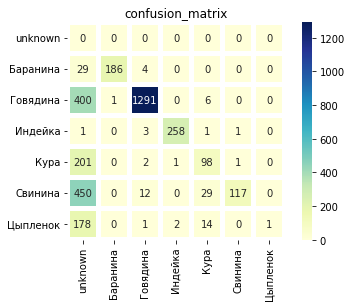

In [91]:
report(y_true, y_pred_manual)

Мы получили довольно низкую точность и матрица ошибок далека от диагонального вида.

###### **2. Baseline: CATBOOST**

В качестве baseline-модели используем catboost. Натренируем 2 модели: с учетом весов классов и без них. Сравним результаты. 

In [34]:
def get_pools(X_train, y_train, X_test, y_test):
    
    train_pool = Pool(data=X_train, 
                      label=y_train, 
                      text_features=['text_lemm'])

    valid_pool = Pool(data=X_test, 
                      label=y_test, 
                      text_features=['text_lemm'])

    return train_pool, valid_pool


def fit_model(train_pool, test_pool, **kwargs):
    
    model = CatBoostClassifier(task_type="GPU",
                               eval_metric='TotalF1', 
                               od_type='Iter', 
                               od_wait=500, 
                               **kwargs)
    
    return model.fit(train_pool, 
                     eval_set=test_pool, 
                     verbose=100, 
                     plot=True, 
                     use_best_model=True)

In [31]:
train_pool, valid_pool = get_pools(X_train, y_train, X_test, y_test)

In [35]:
model = fit_model(train_pool, 
                  valid_pool, 
                  learning_rate=0.35,
                  iterations=1000,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                  feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8637976	test: 0.8650756	best: 0.8650756 (0)	total: 20.7ms	remaining: 20.7s
100:	learn: 0.9617278	test: 0.9508019	best: 0.9522947 (74)	total: 1.14s	remaining: 10.1s
200:	learn: 0.9669580	test: 0.9540688	best: 0.9544375 (141)	total: 2.08s	remaining: 8.25s
300:	learn: 0.9731935	test: 0.9567233	best: 0.9570834 (293)	total: 2.98s	remaining: 6.91s
400:	learn: 0.9785031	test: 0.9577593	best: 0.9580643 (394)	total: 3.85s	remaining: 5.75s
500:	learn: 0.9825821	test: 0.9592920	best: 0.9598730 (493)	total: 4.77s	remaining: 4.75s
600:	learn: 0.9858285	test: 0.9583408	best: 0.9599117 (582)	total: 5.71s	remaining: 3.79s
700:	learn: 0.9889811	test: 0.9594884	best: 0.9599117 (582)	total: 6.64s	remaining: 2.83s
800:	learn: 0.9912953	test: 0.9582325	best: 0.9599117 (582)	total: 7.57s	remaining: 1.88s
900:	learn: 0.9924436	test: 0.9579719	best: 0.9599117 (582)	total: 8.51s	remaining: 935ms
999:	learn: 0.9938240	test: 0.9572745	best: 0.9599117 (582)	total: 9.45s	remaining: 0us
bestTest = 0.959

In [36]:
model_weighted = fit_model(train_pool, 
                          valid_pool, 
                          learning_rate=0.35,
                          iterations=1000,
                          class_weights=class_weights,
                          dictionaries = [{
                              'dictionary_id':'Word',
                              'max_dictionary_size': '50000'
                          }],
                          feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7332675	test: 0.7359965	best: 0.7359965 (0)	total: 20.9ms	remaining: 20.9s
100:	learn: 0.9354587	test: 0.9017012	best: 0.9055088 (65)	total: 1.09s	remaining: 9.73s
200:	learn: 0.9585927	test: 0.9094209	best: 0.9105076 (160)	total: 1.99s	remaining: 7.92s
300:	learn: 0.9717743	test: 0.9093574	best: 0.9106213 (256)	total: 2.92s	remaining: 6.78s
400:	learn: 0.9793740	test: 0.9107584	best: 0.9137217 (386)	total: 3.85s	remaining: 5.75s
500:	learn: 0.9838726	test: 0.9061289	best: 0.9146896 (418)	total: 4.82s	remaining: 4.8s
600:	learn: 0.9896799	test: 0.9064942	best: 0.9146896 (418)	total: 5.78s	remaining: 3.84s
700:	learn: 0.9912883	test: 0.9084533	best: 0.9146896 (418)	total: 6.75s	remaining: 2.88s
800:	learn: 0.9924727	test: 0.9100294	best: 0.9146896 (418)	total: 7.7s	remaining: 1.91s
900:	learn: 0.9932994	test: 0.9105365	best: 0.9146896 (418)	total: 8.64s	remaining: 950ms
bestTest = 0.9146895606
bestIteration = 418
Shrink model to first 419 iterations.


In [37]:
y_pred = get_y_pred(model, valid_pool)
y_pred_weighted = get_y_pred(model_weighted, valid_pool)

              precision    recall  f1-score   support

    Баранина       1.00      0.96      0.98       219
    Говядина       0.98      1.00      0.99      1698
     Индейка       1.00      0.99      0.99       264
        Кура       0.81      0.86      0.83       303
     Свинина       0.99      0.98      0.99       608
    Цыпленок       0.78      0.68      0.73       196

    accuracy                           0.96      3288
   macro avg       0.93      0.91      0.92      3288
weighted avg       0.96      0.96      0.96      3288



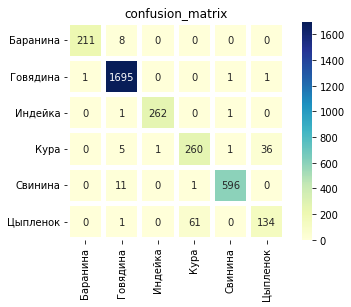

In [39]:
report(y_true, y_pred)

              precision    recall  f1-score   support

    Баранина       0.98      0.97      0.97       219
    Говядина       1.00      0.98      0.99      1698
     Индейка       1.00      0.99      1.00       264
        Кура       0.82      0.84      0.83       303
     Свинина       0.94      0.99      0.96       608
    Цыпленок       0.75      0.72      0.74       196

    accuracy                           0.95      3288
   macro avg       0.91      0.92      0.91      3288
weighted avg       0.95      0.95      0.95      3288



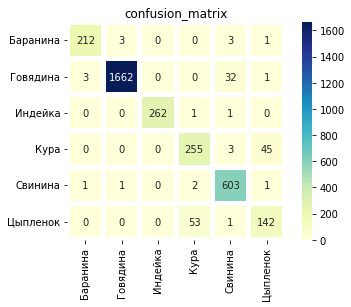

In [40]:
report(y_true, y_pred_weighted)

##### Test examples

In [41]:
test_pool = Pool(data=X_test_example, 
                 label=y_test_example, 
                 text_features=['text_lemm'])

              precision    recall  f1-score   support

    Говядина       1.00      1.00      1.00         2
        Кура       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



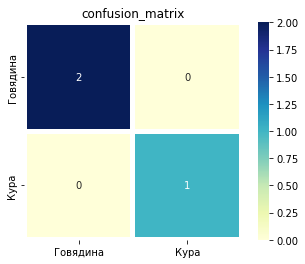

In [86]:
report(y_test_example, model.predict(test_pool))

              precision    recall  f1-score   support

    Говядина       1.00      1.00      1.00         2
        Кура       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



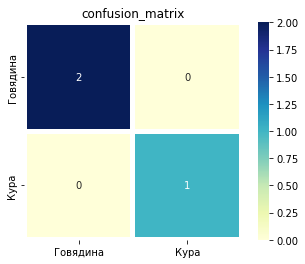

In [87]:
report(y_test_example, model_weighted.predict(test_pool))

###### **Вывод**

Catboost отлично справился с задачей. Добавление весов классов ухудшило точность (0.96 vs. 0.91), измеряемую с помощью catboost, однако метрики посчитанные с помощью sklearn у обеих моделей высоки и близки друг к другу. Обе модели правильно классифицировали 3 тестовых примера. В целом, можно было бы заниматься дальнейшим finetuning'ом данной модели и способами обработки текста, так как catboost простая и интерпретируемая модель. Однако, поскольку одним из условий данного задания является использование PyTorch, попробуем натренировать нейросетевой классификатор.

###### **EmbeddingBag**

Построим простейший классификатор, состоящий из слоя EmbeddingBag и полносвязного слоя.

In [44]:
import time

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

In [45]:
def yield_tokens(X_train):
    for _, row in tqdm(X_train.iterrows()):
        yield row.text_lemm.split()

In [46]:
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

13150it [00:00, 17986.39it/s]


In [48]:
label2num = {'Говядина': 0,
             'Свинина': 1, 
             'Цыпленок': 2, 
             'Кура': 3, 
             'Баранина': 4, 
             'Индейка': 5}


num2label = {0: 'Говядина',
             1: 'Свинина', 
             2: 'Цыпленок', 
             3: 'Кура', 
             4: 'Баранина', 
             5: 'Индейка'}


text_pipeline = lambda x: vocab(x.split())
label_pipeline = lambda x: label2num[x]

In [58]:
def prepare_iter(X_train, y_train, X_test, y_test):
    train_iter = [(label, text) for (label, text) in zip(y_train.mtype.tolist(), X_train.text_lemm.tolist())]
    test_iter = [(label, text) for (label, text) in zip(y_test.mtype.tolist(), X_test.text_lemm.tolist())]
    return train_iter, test_iter


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


def prepare_loaders(train_iter, test_iter, batch_size=16):
        
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)

    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_loader = DataLoader(split_train_, 
                              batch_size=batch_size,
                              shuffle=True, 
                              collate_fn=collate_batch)

    valid_loader = DataLoader(split_valid_, 
                              batch_size=batch_size,
                              shuffle=True, 
                              collate_fn=collate_batch)

    test_loader = DataLoader(test_dataset, 
                             batch_size=batch_size,
                             shuffle=True, 
                             collate_fn=collate_batch)

    return train_loader, valid_loader, test_loader
                                      

def df2loaders(X_train, y_train, X_test, y_test, batch_size=16):
    train_iter, test_iter = prepare_iter(X_train, y_train, X_test, y_test)
    train_loader, valid_loader, test_loader = prepare_loaders(train_iter, test_iter, batch_size=batch_size)
    return train_loader, valid_loader, test_loader
    
    
    
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

    
    
class Classifier:
    
    def __init__(self, 
                 num_class=6,
                 emsize=64,                 
                 vocab_size=len(vocab)):
        
        self.model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
        
    
    def train(self, dataloader, epoch):
        
        self.model.train()
        total_acc, total_count = 0, 0
        log_interval = 500
        start_time = time.time()

        for idx, (label, text, offsets) in enumerate(dataloader):
            self.optimizer.zero_grad()
            predicted_label = self.model(text, offsets)
            loss = self.criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.optimizer.step()
                                  
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            if idx % log_interval == 0 and idx > 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches '
                      '| accuracy {:8.3f}'.format(epoch, 
                                                  idx, 
                                                  len(dataloader),
                                                  total_acc/total_count))
                total_acc, total_count = 0, 0
                start_time = time.time()

        
    def evaluate(self, dataloader):
        
        self.model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad():
            for idx, (label, text, offsets) in enumerate(dataloader):
                predicted_label = self.model(text, offsets)
                loss = self.criterion(predicted_label, label)
                total_acc += (predicted_label.argmax(1) == label).sum().item()
                total_count += label.size(0)
        return total_acc/total_count

    
    def test(self, dataloader):
        y_true = []
        y_pred = []
        with torch.no_grad():
            for idx, (label, text, offsets) in enumerate(dataloader):
                y_true.extend(label.cpu().tolist())
                predicted_proba = self.model(text, offsets)
                predicted_label = predicted_proba.argmax(1).cpu().tolist()
                y_pred.extend(predicted_label)
                
        y_true = [num2label[i] for i in y_true]
        y_pred = [num2label[i] for i in y_pred]
        report(y_true, y_pred)

    
    def fit(self,
            X_train, 
            y_train, 
            X_test, 
            y_test,
            batch_size=16, 
            epochs=10,
            lr=5):
                                      
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1.0, gamma=0.1)
        
        train_loader, valid_loader, test_loader = \
        df2loaders(X_train, y_train, X_test, y_test, batch_size=batch_size)
        
        total_accu = None
        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            self.train(train_loader, epoch)
            accu_val = self.evaluate(valid_loader)
            if total_accu is not None and total_accu > accu_val:
                self.scheduler.step()
            else:
                total_accu = accu_val
                
            print('-' * 59)
            print('| end of epoch {:3d} | time: {:5.2f}s | '
                  'valid accuracy {:8.3f} '.format(epoch,
                                                   time.time() - epoch_start_time,
                                                   accu_val))
            print('-' * 59)
            
        
        accu_test = self.evaluate(test_loader)
        print()
        print(f"TEST ACCURACY: {accu_test}")
        print()
        print()
        self.test(test_loader)

| epoch   1 |   500/  781 batches | accuracy    0.907
-----------------------------------------------------------
| end of epoch   1 | time:  1.47s | valid accuracy    0.962 
-----------------------------------------------------------
| epoch   2 |   500/  781 batches | accuracy    0.959
-----------------------------------------------------------
| end of epoch   2 | time:  1.45s | valid accuracy    0.962 
-----------------------------------------------------------
| epoch   3 |   500/  781 batches | accuracy    0.964
-----------------------------------------------------------
| end of epoch   3 | time:  1.45s | valid accuracy    0.960 
-----------------------------------------------------------
| epoch   4 |   500/  781 batches | accuracy    0.968
-----------------------------------------------------------
| end of epoch   4 | time:  1.43s | valid accuracy    0.967 
-----------------------------------------------------------
| epoch   5 |   500/  781 batches | accuracy    0.974
------

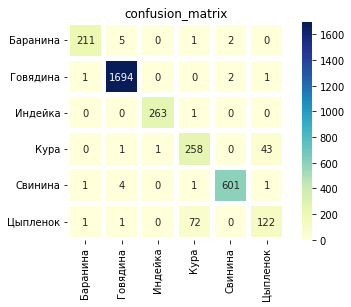

In [59]:
clf = Classifier()

clf.fit(X_train, 
        y_train, 
        X_test, 
        y_test,
        batch_size=16, 
        epochs=10,
        lr=5)

In [84]:
_, _, test_example_loader = \
df2loaders(X_test_example, y_test_example, 
           X_test_example, y_test_example,  
           batch_size=3)

              precision    recall  f1-score   support

    Говядина       1.00      1.00      1.00         2
        Кура       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



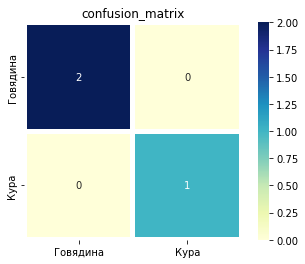

In [85]:
clf.test(test_example_loader)

###### **Вывод**

По точности данная модель показывает такие же хорошие результаты, как catboost. 3 тестовых примера классифицируются правильно. Для еще большего повышения точности, можно было бы попробовать натренировать модель на большем корпусе, а потом дообучить на нашей задаче. Или же, можно было бы использовать претренированную на большом корпусе модель из HuggingFace.